In [1]:
import dgl.function as fn
import torch 
import dgl 
import torch.nn.functional as F
import pickle 
import numpy as np
import time
import os
from dgl.nn.pytorch import Set2Set, NNConv, SetTransformerDecoder, AvgPooling, SumPooling, MaxPooling, SortPooling

In [2]:
class CrystalLoader(object):
    def __init__(self,path_to_pkl):
        self.path_to_pkl = path_to_pkl
        self._load()
    def _load(self):
        with open(self.path_to_pkl,'rb') as infile:
            self.graphs = pickle.load(infile)
        self.targets = torch.Tensor(np.array([graph.target for graph in self.graphs]).reshape(-1, 1).astype(np.float32))
        self.details =[{'adsorbate':graph.adsorbate,
         'miller':graph.miller,
         'comp':graph.comp,
          'mpid':graph.mpid} for graph in self.graphs]
    def __getitem__(self, item):
        g, target = self.graphs[item], self.targets[item]
        return g, target
    def __len__(self):
        return len(self.graphs)

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [4]:
data = CrystalLoader('/scratch/westgroup/mpnn/gasdb_dgl_graphs/init_gasdb_dgl_graphs.pkl')

In [5]:
def collate_crystal_graphs_for_regression(data):
    graphs, targets = map(list, zip(*data))
    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(targets, dim=0)
    return bg, labels

In [6]:
train_loader = torch.utils.data.DataLoader(
        data,
        batch_size=20,
        collate_fn=collate_crystal_graphs_for_regression,
        num_workers=8,)
valid_loader = torch.utils.data.DataLoader(
        data[800:],
        batch_size=20,
        collate_fn=collate_crystal_graphs_for_regression,
        num_workers=8,)

In [7]:
class CG(torch.nn.Module):
    def __init__(self,
                atom_hidden_feats,
                bond_in_feats,
                 ):
        super(CG, self).__init__()
        self.atom_hidden_feats = atom_hidden_feats
        self.bond_in_feats = bond_in_feats
        self.lin = torch.nn.Linear(2*atom_hidden_feats+bond_in_feats,
                                   atom_hidden_feats,bias=True)
        self.sigmoid = torch.nn.Sigmoid()
        self.softplus = torch.nn.LeakyReLU()

    def get_msg(self, edges):
        z = torch.cat([edges.src['v'], edges.dst['v'],edges.data['gdf_feat']], -1)
        z = self.lin(z)
        sig_z = self.sigmoid(z)
        softplus_z = self.softplus(z)
        return {'z':sig_z*softplus_z}
    def forward(self, graph, feat):
        graph = graph.local_var()
        graph.ndata['v'] = feat
        graph.update_all(message_func=self.get_msg,
                     reduce_func=fn.sum('z', 'm'))
        return graph.ndata['m']

In [8]:
class CGConvNet(torch.nn.Module):
    def __init__(self, atom_in_feats=100, 
                 atom_hidden_feats=64,
                 bond_in_feats=41,
                 n_conv=3,
                 n_h=1,
                 graph_rep_dim=64,
                 pooling='sum'
                ):
        super(CGConvNet, self).__init__()
        self.atom_in_feats = atom_in_feats
        self.atom_hidden_feats = atom_hidden_feats
        self.bond_in_feats = bond_in_feats
        self.n_conv = n_conv
        self.n_h = n_h
        self.graph_rep_dim = graph_rep_dim
        self.conv_layer = CG(atom_hidden_feats=atom_hidden_feats,
                             bond_in_feats = bond_in_feats
                            )
        if pooling=='sum':
            self.pooling_module = SumPooling()
        self.lin0 = torch.nn.Linear(atom_in_feats, atom_hidden_feats, bias=True)
        self.lin1 = torch.nn.Linear(atom_hidden_feats,graph_rep_dim,bias=True)
        self.lin2 = torch.nn.Linear(graph_rep_dim,1,bias=True)
        
    def forward(self,graph):
        n_feat = graph.ndata.pop('n_feat')   #B, N, atom_in_feats
        out = F.relu(self.lin0(n_feat))
        #v = out.unsqueeze(0) 
        for i in range(self.n_conv):
            #print(f"running iteration {i}")
            out = self.conv_layer(graph, out)
        graph_rep = F.relu(self.pooling_module(graph,out))
        preds = F.relu(self.lin2(graph_rep))
        return preds

In [9]:
def train(train_loader, model, criterion, optimizer, epoch, evaluation):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    error_ratio = AverageMeter()
    total_loss = 0
    total_error = 0

    # switch to train mode
    model.train()

    end = time.time()
    for batch_id, batch_data in enumerate(train_loader):
        # Prepare input data
        if torch.cuda.is_available():
            bg, labels = batch_data
            bg.to(torch.device('cuda'))
            labels = labels.to('cuda')
       
        # Measure data loading time
        data_time.update(time.time() - end)

        optimizer.zero_grad()

        # Compute output
        output = model(bg)
        train_loss = criterion(output, labels)
        train_eval = evaluation(output, labels)
        # Logs
        losses.update(criterion(output, labels).item(), bg.batch_size)
        error_ratio.update((evaluation(output, labels)).item(), bg.batch_size)
        total_loss += train_loss*bg.batch_size
        total_error += train_eval*bg.batch_size
        # compute gradient and do SGD step
        train_loss.backward()
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if batch_id % 20 == 0 and batch_id > 0:

            print(
                'Epoch: [{0}][{1}/{2}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                'Error Ratio {err.val:.4f} ({err.avg:.4f}) \t' .format(
                    epoch,
                    batch_id,
                    len(train_loader),
                    batch_time=batch_time,
                    data_time=data_time,
                    loss=losses,
                    err=error_ratio))
    total_loss = total_loss /len(train_loader.dataset)
    total_error = total_error / len(train_loader.dataset)
    print('epoch {:d}/{:d}, training loss {:.4f}, training score {:.4f}'.format(
        epoch + 1, 100, total_loss, total_error))
    print(os.system("nvidia-smi"))

    print('Epoch: [{0}] Avg Error Ratio {err.avg:.3f}; Average Loss {loss.avg:.3f}; Avg Time x Batch {b_time.avg:.3f}'
          .format(epoch, err=error_ratio, loss=losses, b_time=batch_time))
    return total_loss.detach().cpu().numpy(), total_error.detach().cpu().numpy()


In [10]:
model = CGConvNet()
criterion = torch.nn.MSELoss()
evaluation = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [11]:
if torch.cuda.is_available():
    model =model.to('cuda')
    criterion = criterion.to('cuda')
    evaluation = evaluation.to('cuda')

In [12]:
train_loss, train_error = [], [] 
for epoch in range(100):
    loss, error = train(train_loader= train_loader, 
                        model=model,
                        criterion=criterion, 
                        evaluation=evaluation, 
                        epoch=epoch, 
                        optimizer=optimizer)
    train_loss.append(loss), train_error.append(error)

Epoch: [0][20/50]	Time 0.019 (0.062)	Data 0.014 (0.039)	Loss 367950.9375 (619385.5610)	Error Ratio 483.4173 (656.7005) 	
Epoch: [0][40/50]	Time 0.012 (0.040)	Data 0.007 (0.026)	Loss 171229.1562 (447378.5574)	Error Ratio 336.8304 (545.2579) 	
epoch 1/100, training loss 395418.6562, training score 504.5711
0
Epoch: [0] Avg Error Ratio 504.571; Average Loss 395418.562; Avg Time x Batch 0.035
Epoch: [1][20/50]	Time 0.020 (0.045)	Data 0.014 (0.038)	Loss 29471.1309 (86110.2975)	Error Ratio 115.5363 (199.7495) 	
Epoch: [1][40/50]	Time 0.011 (0.032)	Data 0.006 (0.025)	Loss 14535.5625 (63604.4175)	Error Ratio 73.9134 (163.2737) 	
epoch 2/100, training loss 57438.2109, training score 152.4424
0
Epoch: [1] Avg Error Ratio 152.442; Average Loss 57438.206; Avg Time x Batch 0.028
Epoch: [2][20/50]	Time 0.020 (0.047)	Data 0.014 (0.039)	Loss 4310.2603 (22092.5839)	Error Ratio 33.9297 (73.2555) 	
Epoch: [2][40/50]	Time 0.011 (0.032)	Data 0.006 (0.025)	Loss 2237.0410 (16776.6507)	Error Ratio 24.2140 (61

epoch 23/100, training loss 75.8534, training score 1.5327
0
Epoch: [22] Avg Error Ratio 1.533; Average Loss 75.853; Avg Time x Batch 0.028
Epoch: [23][20/50]	Time 0.020 (0.046)	Data 0.015 (0.038)	Loss 1.6279 (45.7995)	Error Ratio 0.9011 (1.3419) 	
Epoch: [23][40/50]	Time 0.012 (0.032)	Data 0.007 (0.025)	Loss 1.1189 (69.7498)	Error Ratio 0.6514 (1.5027) 	
epoch 24/100, training loss 66.5711, training score 1.4672
0
Epoch: [23] Avg Error Ratio 1.467; Average Loss 66.571; Avg Time x Batch 0.028
Epoch: [24][20/50]	Time 0.020 (0.046)	Data 0.014 (0.038)	Loss 1.6279 (38.5685)	Error Ratio 0.9011 (1.2712) 	
Epoch: [24][40/50]	Time 0.011 (0.032)	Data 0.006 (0.025)	Loss 1.1189 (61.4444)	Error Ratio 0.6514 (1.4376) 	
epoch 25/100, training loss 58.5187, training score 1.4055
0
Epoch: [24] Avg Error Ratio 1.405; Average Loss 58.519; Avg Time x Batch 0.028
Epoch: [25][20/50]	Time 0.020 (0.046)	Data 0.015 (0.037)	Loss 1.6279 (32.5850)	Error Ratio 0.9011 (1.2041) 	
Epoch: [25][40/50]	Time 0.012 (0.03

epoch 46/100, training loss 6.6008, training score 0.7963
0
Epoch: [45] Avg Error Ratio 0.796; Average Loss 6.601; Avg Time x Batch 0.028
Epoch: [46][20/50]	Time 0.021 (0.047)	Data 0.015 (0.038)	Loss 1.6279 (2.4133)	Error Ratio 0.9011 (0.7128) 	
Epoch: [46][40/50]	Time 0.013 (0.033)	Data 0.007 (0.025)	Loss 1.1189 (7.2730)	Error Ratio 0.6514 (0.8138) 	
epoch 47/100, training loss 6.1412, training score 0.7868
0
Epoch: [46] Avg Error Ratio 0.787; Average Loss 6.141; Avg Time x Batch 0.029
Epoch: [47][20/50]	Time 0.020 (0.047)	Data 0.015 (0.039)	Loss 1.6279 (2.2767)	Error Ratio 0.9011 (0.7101) 	
Epoch: [47][40/50]	Time 0.012 (0.032)	Data 0.007 (0.025)	Loss 1.1189 (6.7787)	Error Ratio 0.6514 (0.8059) 	
epoch 48/100, training loss 5.7298, training score 0.7786
0
Epoch: [47] Avg Error Ratio 0.779; Average Loss 5.730; Avg Time x Batch 0.029
Epoch: [48][20/50]	Time 0.021 (0.047)	Data 0.015 (0.038)	Loss 1.6279 (2.1515)	Error Ratio 0.9011 (0.7074) 	
Epoch: [48][40/50]	Time 0.012 (0.033)	Data 0.0

Epoch: [69][20/50]	Time 0.020 (0.047)	Data 0.015 (0.038)	Loss 1.6279 (0.9777)	Error Ratio 0.9011 (0.6665) 	
Epoch: [69][40/50]	Time 0.011 (0.033)	Data 0.006 (0.025)	Loss 1.1189 (1.7462)	Error Ratio 0.6514 (0.6857) 	
epoch 70/100, training loss 1.6030, training score 0.6797
0
Epoch: [69] Avg Error Ratio 0.680; Average Loss 1.603; Avg Time x Batch 0.029
Epoch: [70][20/50]	Time 0.020 (0.047)	Data 0.015 (0.038)	Loss 1.6279 (0.9645)	Error Ratio 0.9011 (0.6653) 	
Epoch: [70][40/50]	Time 0.012 (0.033)	Data 0.007 (0.026)	Loss 1.1189 (1.6711)	Error Ratio 0.6514 (0.6835) 	
epoch 71/100, training loss 1.5414, training score 0.6779
0
Epoch: [70] Avg Error Ratio 0.678; Average Loss 1.541; Avg Time x Batch 0.029
Epoch: [71][20/50]	Time 0.020 (0.047)	Data 0.015 (0.039)	Loss 1.6279 (0.9531)	Error Ratio 0.9011 (0.6641) 	
Epoch: [71][40/50]	Time 0.011 (0.033)	Data 0.006 (0.026)	Loss 1.1189 (1.6022)	Error Ratio 0.6514 (0.6812) 	
epoch 72/100, training loss 1.4849, training score 0.6761
0
Epoch: [71] Avg 

Epoch: [92][40/50]	Time 0.011 (0.033)	Data 0.006 (0.026)	Loss 1.1189 (0.9885)	Error Ratio 0.6514 (0.6530) 	
epoch 93/100, training loss 0.9817, training score 0.6529
0
Epoch: [92] Avg Error Ratio 0.653; Average Loss 0.982; Avg Time x Batch 0.029
Epoch: [93][20/50]	Time 0.020 (0.047)	Data 0.015 (0.039)	Loss 1.6279 (0.9009)	Error Ratio 0.9011 (0.6549) 	
Epoch: [93][40/50]	Time 0.012 (0.033)	Data 0.007 (0.026)	Loss 1.1189 (0.9802)	Error Ratio 0.6514 (0.6524) 	
epoch 94/100, training loss 0.9749, training score 0.6524
0
Epoch: [93] Avg Error Ratio 0.652; Average Loss 0.975; Avg Time x Batch 0.029
Epoch: [94][20/50]	Time 0.021 (0.048)	Data 0.015 (0.039)	Loss 1.6279 (0.9012)	Error Ratio 0.9011 (0.6550) 	
Epoch: [94][40/50]	Time 0.012 (0.033)	Data 0.007 (0.026)	Loss 1.1189 (0.9727)	Error Ratio 0.6514 (0.6519) 	
epoch 95/100, training loss 0.9688, training score 0.6520
0
Epoch: [94] Avg Error Ratio 0.652; Average Loss 0.969; Avg Time x Batch 0.029
Epoch: [95][20/50]	Time 0.020 (0.047)	Data 0.0

In [14]:
train_loss = np.array(train_loss)
train_error = np.array(train_error)

In [21]:
from matplotlib import pyplot as plt
%matplotlib inline

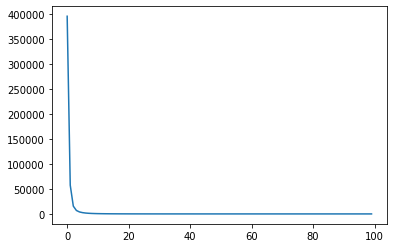

In [22]:
plt.plot(range(100),train_loss[0])

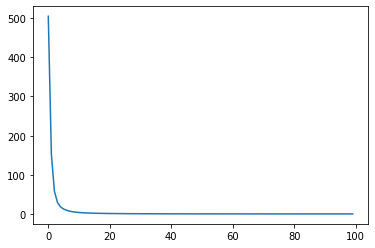

In [24]:
plt.plot(range(100),train_error)

In [26]:
!nvidia-smi

Tue Apr 14 15:13:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.48                 Driver Version: 410.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   40C    P0    37W / 250W |   1222MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:D8:00.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |     11MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        